# RFS Regression Test File

Import local libraries for modelling the training data

In [1]:
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Scaling and pipline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Model Implementation
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error



Reference local paths to:
1. Training dataset
2. Testing dataset
3. A excel file for displaying the results

In [2]:
TEST_PATH = "../testDataSetExample.xls" 
TRAIN_PATH = "../trainDataset.csv" 
RESULTS_PATH = "../resultsRFS.csv" 

For xls imports install the xlrd dependancy below:

$conda install xlrd

# Preprocessing Training Data

All methods with in the preprocessing stage is described more clearly in other files

In [3]:
# Assign training data to variable ds
ds = pd.read_csv(TRAIN_PATH)
ds.head()

# Remove null cases (999) from the training dataset
ds= ds[~(ds == 999).any(axis=1)]
ds.shape

# Rounding Age to nearest whole number
ds['Age'] = ds['Age'].round()
ds['Age'] = ds['Age'].astype(int)

# Removing singular instance from ChemoGrade
ds["ChemoGrade"] = ds["ChemoGrade"].replace(1,2)
ds["ChemoGrade"].value_counts()

# Split training data to clinical and image features
data_clinical = ds.iloc[:,1:13]
data_image = ds.iloc[:,13:]

new_data_cl = data_clinical.drop(columns=['pCR (outcome)'])

# Assign X and y
y = data_clinical['RelapseFreeSurvival (outcome)']
train_X_cl = new_data_cl.drop(columns=['RelapseFreeSurvival (outcome)'])

train_X_cl_col = train_X_cl.columns
train_X_cl_real = train_X_cl

# Feature Selection using Random Forest Regressor
Convert the clinical data first

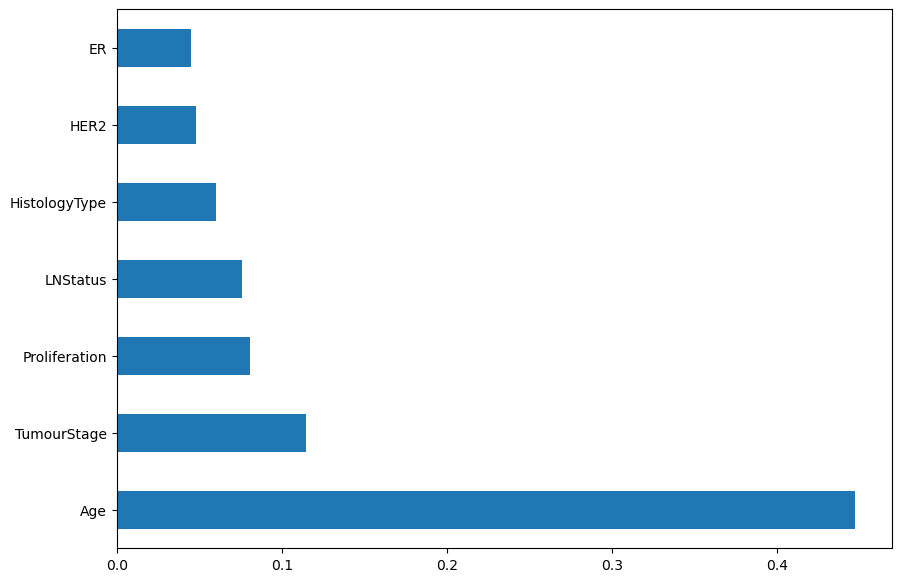

In [4]:
# Create object of the RandomForestRegressor
model_RFR = RandomForestRegressor(max_depth=10)

# Fit the model with the training data
model_RFR.fit(train_X_cl, y)

# Picking out the best features from bar chart
plt.figure(figsize=(10,7))
feat_importances_cl = pd.Series(model_RFR.feature_importances_, index = train_X_cl.columns)
feat_importances_cl.nlargest(7).plot(kind='barh');

In [5]:
# List of important features from clinical data
feat_importances_cl = feat_importances_cl.nlargest(7)
feat_importances_cl.index

Index(['Age', 'TumourStage', 'Proliferation', 'LNStatus', 'HistologyType',
       'HER2', 'ER'],
      dtype='object')

In [6]:
# Reduced clinical data after feature selection
train_X_fs =  train_X_cl_real[list(feat_importances_cl.index)]

In [7]:
train_X_fs.columns

Index(['Age', 'TumourStage', 'Proliferation', 'LNStatus', 'HistologyType',
       'HER2', 'ER'],
      dtype='object')

Next convert the image data

In [8]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(data_image, y)

RandomForestRegressor()

(390, 30)

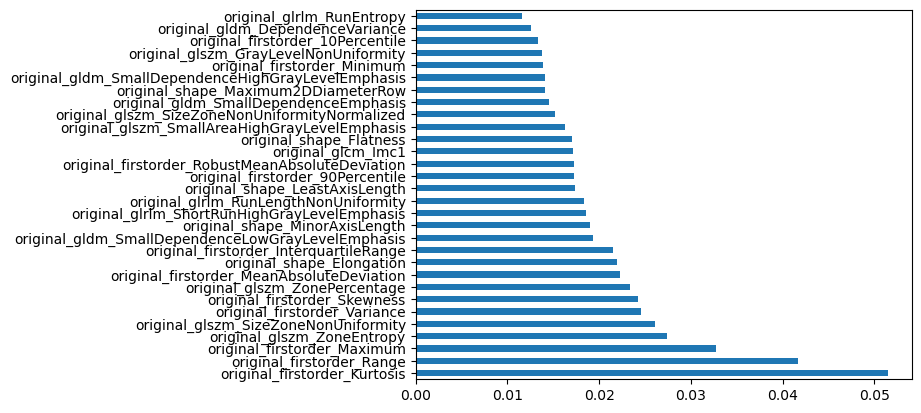

In [9]:
feat_importances = pd.Series(rf.feature_importances_, index = data_image.columns)
feat_importances.nlargest(30).plot(kind='barh');

feat_importances = feat_importances.nlargest(30)
train_img_X_fs = data_image[list(feat_importances.index)]

train_img_X_fs.shape

Combine both clinical data and image data into one dataset

In [10]:
train_data = pd.concat([train_X_fs, train_img_X_fs], axis=1)
train_data.columns.size

37

In [11]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
sc = StandardScaler()

numeric_features = train_data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = train_data.select_dtypes(include=['object']).columns

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])

# Training the model

Using linear regression

In [12]:
#Fit X and y 
lr.fit(train_data, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'TumourStage', 'Proliferation', 'LNStatus', 'HistologyType',
       'HER2', 'ER', 'original_firstorder_Kurtosis',
       'original_firstorder_Range', 'original_firstorder_Maximum',
       'original_glszm_Z...
       'original_firstorder_Minimum', 'original_glszm_GrayLevelNonUniformity',
       'original_firstorder_10Percentile', 'original_gldm_DependenceVariance',
       'original_glrlm_RunEntropy'],
      dtype='object')),
                                                 ('cat',
                

# Testing
Do the same preprocessing and feature reduction to the testing dataset

In [13]:
# Assign training data to variable ds
ds_test = pd.read_excel(TEST_PATH)
ds_test.head()

# Remove null cases (999) from the training dataset
ds_test= ds_test[~(ds_test == 999).any(axis=1)]
ds_test.shape

# Save the ids
IDs = ds_test.iloc[:,0]

# Rounding Age to nearest whole number
ds_test['Age'] = ds_test['Age'].round()
ds_test['Age'] = ds_test['Age'].astype(int)

# Removing singular instance from ChemoGrade
ds_test["ChemoGrade"] = ds_test["ChemoGrade"].replace(1,2)
ds_test["ChemoGrade"].value_counts()

# Split training data to clinical and image features
data_clinical = ds_test.iloc[:,1:11]
data_image = ds_test.iloc[:,11:]

# Assign X clinical (test data)
train_X_cl = data_clinical

Apply feature selection for both clincal and image data

In [14]:
# Reduced clinical data after feature selection
train_X_fs =  data_clinical[list(feat_importances_cl.index)]

# Reduced image data after feature selection
#item_list = [e for e in list(feat_importances.index) if e not in ('original_shape_Elongation', 'original_shape_Flatness')]

train_img_X_fs = data_image[list(feat_importances.index)]

test_data = pd.concat([train_X_fs, train_img_X_fs], axis=1)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
sc = StandardScaler()

numeric_features = test_data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = test_data.select_dtypes(include=['object']).columns

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

,Age,TumourStage,Proliferation,LNStatus,HistologyType,HER2,ER,original_firstorder_Kurtosis,original_firstorder_Range,original_firstorder_Maximum,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SizeZoneNonUniformityNormalized,original_gldm_SmallDependenceEmphasis,original_shape_Maximum2DDiameterRow,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_firstorder_Minimum,original_glszm_GrayLevelNonUniformity,original_firstorder_10Percentile,original_gldm_DependenceVariance,original_glrlm_RunEntropy
1,60,3,1,0,1,1,0,2.464230,5.801544,4.766428,...,0.309999,0.187146,0.008538,33.301652,0.016434,-1.035116,17.782609,0.346204,39.735035,3.315905
2,58,4,3,1,1,0,0,2.151791,6.801564,5.178547,...,0.328377,0.120869,0.006328,37.107951,0.012334,-1.623018,45.042553,-0.040551,44.245345,3.834531
4,60,3,1,0,1,1,0,2.464230,5.801544,4.766428,...,0.309999,0.187146,0.008538,33.301652,0.016434,-1.035116,17.782609,0.346204,39.735035,3.315905
5,58,4,3,1,1,0,0,2.151791,6.801564,5.178547,...,0.328377,0.120869,0.006328,37.107951,0.012334,-1.623018,45.042553,-0.040551,44.245345,3.834531
7,60,3,1,0,1,1,0,2.464230,5.801544,4.766428,...,0.309999,0.187146,0.008538,33.301652,0.016434,-1.035116,17.782609,0.346204,39.735035,3.315905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,58,4,3,1,1,0,0,2.151791,6.801564,5.178547,...,0.328377,0.120869,0.006328,37.107951,0.012334,-1.623018,45.042553,-0.040551,44.245345,3.834531
103,60,3,1,0,1,1,0,2.464230,5.801544,4.766428,...,0.309999,0.187146,0.008538,33.301652,0.016434,-1.035116,17.782609,0.346204,39.735035,3.315905
104,58,4,3,1,1,0,0,2.151791,6.801564,5.178547,...,0.328377,0.120869,0.006328,37.107951,0.012334,-1.623018,45.042553,-0.040551,44.245345,3.834531
106,60,3,1,0,1,1,0,2.464230,5.801544,4.766428,...,0.309999,0.187146,0.008538,33.301652,0.016434,-1.035116,17.782609,0.346204,39.735035,3.315905


In [15]:
y_pred = lr.predict(X_df)

output = pd.DataFrame(columns=['ID', 'RFS (Prediction)'])
output['ID'] = IDs
output['RFS (Prediction)'] = y_pred

output.to_csv(RESULTS_PATH)